In [295]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, List
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field

load_dotenv()

True

In [296]:
model = ChatOpenAI(model_name="gpt-4o-mini")

In [297]:
class Review(BaseModel):
    sentiment: Literal['support_team_reply', 'product_team_reply', 'marketing_team_reply'] =  Field(..., description="Decide which team should handle this customer review.'support_team_reply', 'product_team_reply', 'marketing_team_reply' ")

structure_model = model.with_structured_output(Review)    


In [298]:
class diagonisisSchema(BaseModel):
    issue: str
    severity: Literal['low', 'medium', 'high']

sturcture_model_diagnosis = model.with_structured_output(diagonisisSchema)    



In [299]:
class CustomerReview(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative', 'neutral']
    diagonisis : diagonisisSchema
    route_decision: Literal['support_team_reply',"product_team_reply","marketing_team_reply"]
    reply: str




In [300]:
def find_sentiment(state: CustomerReview) -> CustomerReview:
    review = state['review']
    
    prompt = f"""Decide which team should handle this customer review.
    Options: 'support_team_reply', 'product_team_reply', 'marketing_team_reply'
    Review: \"{review}\""""
    route_decision = structure_model.invoke(prompt)
    return {"route_decision": route_decision.sentiment}


In [301]:
def support_team_reply(state: CustomerReview) -> CustomerReview:
    review = state['review']
    
    prompt = f"Support team reply to this review: \"{review}\""
    reply = model.invoke(prompt)
    
    return {"reply": reply}

In [302]:
def product_team_reply(state: CustomerReview) -> CustomerReview:
    review = state['review']
    
    prompt = f"Product team reply to this review: \"{review}\""
    reply = model.invoke(prompt)
    
    return {"reply": reply}

In [303]:
def marketing_team_reply(state: CustomerReview) -> CustomerReview:
    review = state['review']
    
    prompt = f"Marketing team reply to this review: \"{review}\""
    reply = structure_model.invoke(prompt)
    
    return {"reply": reply}

In [304]:
def check_route_decision(state: CustomerReview) -> Literal['support_team_reply', 'product_team_reply', 'marketing_team_reply']:
    route_decision = state['route_decision']
    
    if route_decision == "support_team_reply":
        return 'support_team_reply'
    elif route_decision == "product_team_reply":
        return 'product_team_reply'
    elif route_decision == "marketing_team_reply":
        return 'marketing_team_reply'
    else:
        raise ValueError("Invalid route decision")

In [305]:
state_graph = StateGraph(CustomerReview)
state_graph.add_node("find_sentiment", find_sentiment)
state_graph.add_node("support_team_reply",support_team_reply)
state_graph.add_node("product_team_reply",product_team_reply)
state_graph.add_node("marketing_team_reply",marketing_team_reply)

state_graph.add_edge(START, "find_sentiment")
# state_graph.add_edge("find_sentiment","check_route_decision") 
state_graph.add_conditional_edges("find_sentiment", check_route_decision, {
    "support_team_reply": "support_team_reply",
    "product_team_reply": "product_team_reply",
    "marketing_team_reply": "marketing_team_reply"
})

state_graph.add_edge("support_team_reply", END)
state_graph.add_edge("product_team_reply", END)
state_graph.add_edge("marketing_team_reply", END)

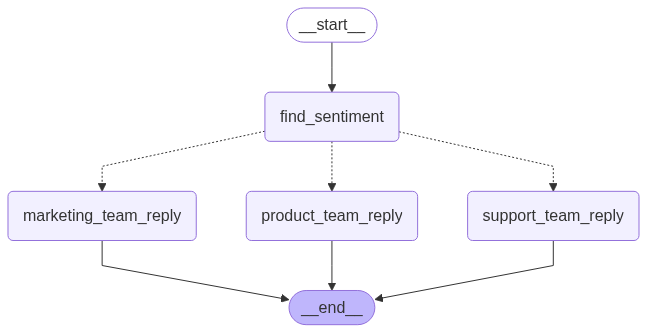

In [306]:
workflow = state_graph.compile()

workflow

In [307]:
initial_state={
    "review": "The new update broke several features I use daily. Please roll back the changes or fix them soon.",
    
}

workflow.invoke(initial_state)

{'review': 'The new update broke several features I use daily. Please roll back the changes or fix them soon.',
 'route_decision': 'support_team_reply',
 'reply': AIMessage(content="Subject: Thank You for Your Feedback\n\nHi [Reviewer’s Name],\n\nThank you for taking the time to share your thoughts with us. We sincerely apologize for the issues you've experienced since the recent update. We understand how frustrating it can be when features you rely on aren't functioning as expected.\n\nOur team is aware of these concerns and is actively working on a solution to restore these features as quickly as possible. Your feedback is invaluable in helping us improve, and we appreciate your patience during this time.\n\nIf you have any specific features that you're having trouble with, please feel free to share them with us. We want to ensure that we address all your concerns effectively.\n\nThank you for your understanding!\n\nBest regards,  \n[Your Name]  \nCustomer Support Team  \n[Your Compa